In [1]:
import fastbook
fastbook.setup_book()

In [2]:
from fastai.vision.all import *
from fastbook import *
matplotlib.rc('image',cmap='Greys')

In [3]:
top_edge=tensor([[-1,-1,-1],
                [0,0,0],
                [1,1,1]]).float()

In [4]:
path=untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH=path

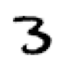

In [5]:
im3=Image.open(path/'train'/'3'/'12.png')
show_image(im3);

In [10]:
im3_t=tensor(im3)
im3_t[0:3,0:3] * top_edge

tensor([[-0., -0., -0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [11]:
(im3_t[0:3,0:3]*top_edge).sum()

tensor(0.)

In [12]:
df=pd.DataFrame(im3_t[:10,:20])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


In [13]:
(im3_t[4:7,6:9]*top_edge).sum()

tensor(762.)

In [14]:
(im3_t[7:10,17:20]*top_edge).sum()

tensor(-29.)

In [15]:
def apply_kernel(row,col,kernel):
    return (im3_t[row-1:row+2,col-1:col+2]*kernel).sum()

In [16]:
apply_kernel(5,7,top_edge)

tensor(762.)

In [17]:
[[(i,j) for j in range(1,5)] for i in range(1,5)]

[[(1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 1), (4, 2), (4, 3), (4, 4)]]

<AxesSubplot:>

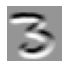

In [20]:
rng=range(1,27)
top_edge3=tensor([[apply_kernel(i,j,top_edge) for j in rng] for i in rng])
show_image(top_edge3)

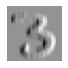

In [22]:
left_edge=tensor([[-1,1,0],
                 [-1,1,0],
                [-1,1,0]]).float()
left_edge3=tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng])
show_image(left_edge3);

In [25]:
diag1_edge=tensor([[0,-1,1],
                  [-1,1,0],
                  [1,0,0]]).float()
diag2_edge=tensor([[1,-1,0],
                  [0,1,-1],
                  [0,0,1]]).float()
edge_kernels=torch.stack([left_edge,top_edge,diag1_edge,diag2_edge])
edge_kernels.shape

torch.Size([4, 3, 3])

In [27]:
mnist=DataBlock((ImageBlock(cls=PILImageBW),CategoryBlock),
               get_items=get_image_files,
               splitter=GrandparentSplitter(),
               get_y=parent_label)
dls=mnist.dataloaders(path)
xb,yb=first(dls.valid)
xb.shape

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


torch.Size([64, 1, 28, 28])

In [28]:
xb,yb=to_cpu(xb),to_cpu(yb)

In [29]:
edge_kernels.shape,edge_kernels.unsqueeze(1).shape

(torch.Size([4, 3, 3]), torch.Size([4, 1, 3, 3]))

In [30]:
edge_kernels=edge_kernels.unsqueeze(1)

In [31]:
batch_features=F.conv2d(xb,edge_kernels)
batch_features.shape

torch.Size([64, 4, 26, 26])

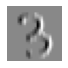

In [32]:
show_image(batch_features[0,0]);

# Creating the CNN

In [33]:
simple_net=nn.Sequential(
nn.Linear(28*28,30),
nn.ReLU(),
nn.Linear(30,1))

In [34]:
simple_net

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

In [35]:
broken_cnn=sequential(
nn.Conv2d(1,30,kernel_size=3,padding=1),
nn.ReLU(),
nn.Conv2d(30,1,kernel_size=3,padding=1))

In [36]:
broken_cnn(xb).shape

torch.Size([64, 1, 28, 28])

In [39]:
def conv(ni,nf,ks=3,act=True):
    res=nn.Conv2d(ni,nf,stride=2,kernel_size=ks,padding=ks//2)
    if act: res=nn.Sequential(res,nn.ReLU())
    return res

In [40]:
simple_cnn=sequential(
conv(1,4),
conv(4,8),
conv(8,16),
conv(16,32),
conv(32,2,act=False),
Flatten(),
)

In [41]:
simple_cnn(xb).shape

torch.Size([64, 2])

In [42]:
learn=Learner(dls,simple_cnn,loss_func=F.cross_entropy,metrics=accuracy)

In [43]:
learn.summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                          

In [44]:
learn.fit_one_cycle(2,0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.066732,0.046529,0.983317,00:25
1,0.021137,0.023017,0.992640,00:16


In [45]:
m=learn.model[0]
m

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)

In [46]:
m[0].weight.shape

torch.Size([4, 1, 3, 3])

In [47]:
m[0].bias.shape

torch.Size([4])

In [48]:
im=image2tensor(Image.open(image_bear()))
im.shape

torch.Size([3, 1000, 846])

<AxesSubplot:>

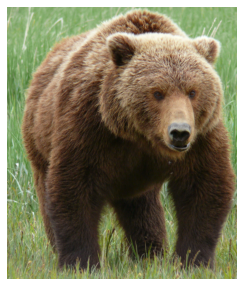

In [49]:
show_image(im)

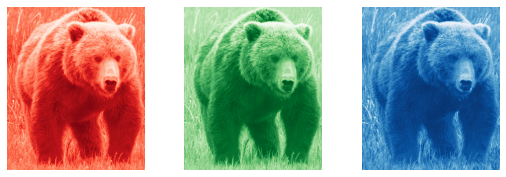

In [52]:
_,axs=subplots(1,3)
for bear,ax,color in zip(im,axs,('Reds','Greens','Blues')):
    show_image(255-bear,ax=ax,cmap=color)

In [53]:
path=untar_data(URLs.MNIST)
Path.BASE_PATH=path

In [54]:
path.ls()

(#2) [Path('testing'),Path('training')]

In [55]:
def get_dls(bs=15):
    return DataBlock(
            blocks=(ImageBlock(cls=PILImageBW),CategoryBlock),
            get_items=get_image_files,
            splitter=GrandparentSplitter('training','testing'),
            get_y=parent_label,
            batch_tfms=Normalize()
        ).dataloaders(path,bs=bs)

In [56]:
dls=get_dls()

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


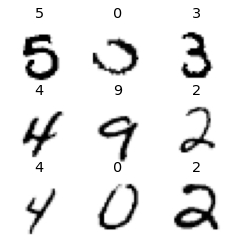

In [57]:
dls.show_batch(max_n=9,figsize=(4,4))

In [58]:
def conv(ni,nf,ks=3,act=True):
    res=nn.Conv2d(ni,nf,stride=2,kernel_size=ks,padding=ks//2)
    if act: res=nn.Sequential(res,nn.ReLU())
    return res

In [59]:
def simple_cnn():
    return sequential(
    conv(1,8,ks=5),
    conv(8,16),
    conv(16,32),
    conv(32,64),
    conv(64,10,act=False),
    Flatten(),
    )

In [60]:
from fastai.callback.hook import *

In [61]:
def fit(epochs=1):
    learn=Learner(dls,simple_cnn(),loss_func=F.cross_entropy,
                 metrics=accuracy,cbs=ActivationStats(with_hist=True))
    learn.fit(epochs,0.06)
    return learn

In [62]:
learn=fit()

C:\Users\mayan\anaconda3\envs\GPU\lib\site-packages\fastai\callback\core.py:51: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,2.313106,2.313628,0.102800,02:45


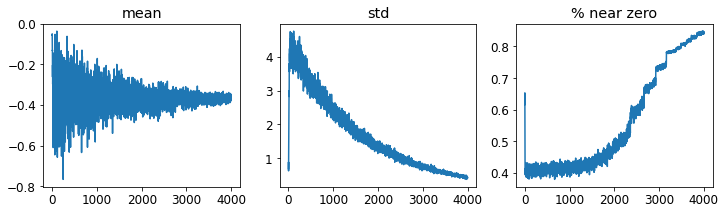

In [63]:
learn.activation_stats.plot_layer_stats(0)

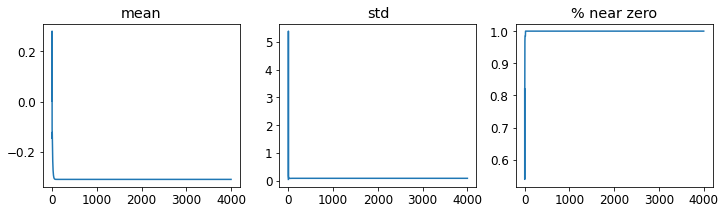

In [64]:
learn.activation_stats.plot_layer_stats(-2)

In [65]:
dls=get_dls(512)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [66]:
learn=fit()

C:\Users\mayan\anaconda3\envs\GPU\lib\site-packages\fastai\callback\core.py:51: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,2.316985,2.302484,0.113500,01:12


In [69]:
def fit(epochs=1,lr=0.06):
    learn=Learner(dls,simple_cnn(),loss_func=F.cross_entropy,
                 metrics=accuracy,cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs,lr)
    return learn

In [70]:
learn=fit()

C:\Users\mayan\anaconda3\envs\GPU\lib\site-packages\fastai\callback\core.py:51: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.216320,0.077756,0.974100,01:14


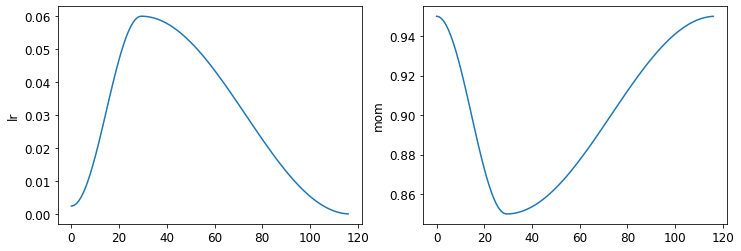

In [71]:
learn.recorder.plot_sched()

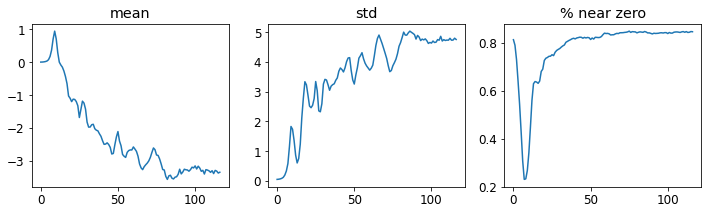

In [72]:
learn.activation_stats.plot_layer_stats(-2)

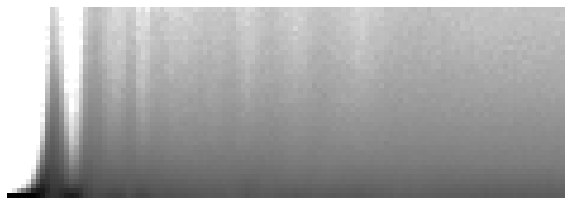

In [73]:
learn.activation_stats.color_dim(-2)

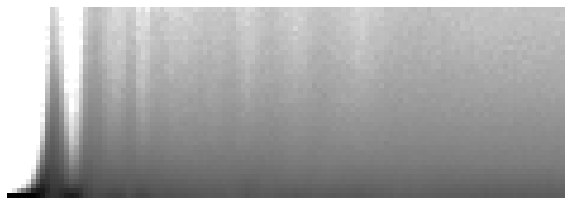

In [74]:
learn.activation_stats.color_dim(-2)

In [75]:
def conv(ni,nf,ks=3,act=True):
    layers=[nn.Conv2d(ni,nf,stride=2,kernel_size=ks,padding=ks//2)]
    if act: layers.append(nn.ReLU())
    layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)

In [76]:
learn=fit()

C:\Users\mayan\anaconda3\envs\GPU\lib\site-packages\fastai\callback\core.py:51: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.136770,0.058243,0.985200,01:15


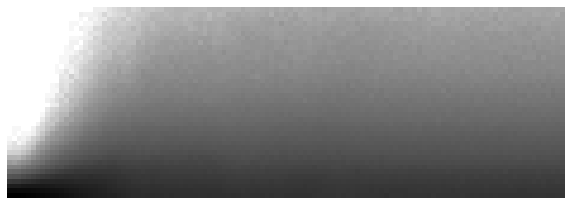

In [77]:
learn.activation_stats.color_dim(-4)

In [78]:
learn=fit(5,lr=0.1)

C:\Users\mayan\anaconda3\envs\GPU\lib\site-packages\fastai\callback\core.py:51: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.191105,0.105265,0.969100,01:13
1,0.082114,0.071688,0.977000,01:13
2,0.051548,0.056094,0.981300,01:13
3,0.031282,0.030093,0.989300,01:13
4,0.016260,0.025620,0.990700,01:13
